In [286]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import rcParams
from termcolor import colored
import scipy.stats as stats
import seaborn as sns
import numpy as np  
from prettytable import PrettyTable
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb


In [287]:
rcParams['figure.figsize'] = 12, 5

In [288]:
class ForecastPetroleo():
    def __init__(self, ticker="BZ=F"):
        self.ticker = ticker
        self.data = yf.download(ticker)
        self.df = self.create_features(self.data)



    def fit(self):
        return self
    
    def create_features(self, df):
        data_frame = df.copy()
        data_frame["data"] = pd.to_datetime(df.index)
        data_frame['ano'] = data_frame['data'].dt.year
        data_frame['mes'] = data_frame['data'].dt.month
        data_frame['dia'] = data_frame['data'].dt.day
        data_frame.rename(columns={'Close': 'valor_fechamento'}, inplace=True)
        data_frame.rename(columns={'Open': 'valor_abertura'}, inplace=True)        
        data_frame['dia_da_semana'] = data_frame['data'].dt.dayofweek
        
        return data_frame

    def plotarSerie(self, serie, titulo="Valores do petroleo com base no fechamento diário", legendas=[]):        
        serie.plot()    
        plt.title(titulo)
        plt.xlabel('Data')
        plt.grid(visible=True, linestyle='-', linewidth=0.7)
        plt.ylabel('Valor em Dolar')
        if legendas:
            plt.legend(labels=legendas, loc='best')
    
    def plotar_medias_moveis(self, serie, titulo ='Valor Fechamento Petroleo com média móvel' ):
        dias_uteis = 22
        serie_media_movel_30 = serie.rolling(dias_uteis).mean()
        serie_media_movel_90 = serie.rolling(dias_uteis * 3).mean()
        serie_media_movel_anual = serie.rolling(dias_uteis * 12).mean()
        self.plotarSerie(serie)
        self.plotarSerie(serie_media_movel_30)
        self.plotarSerie(serie_media_movel_90)
        self.plotarSerie(serie_media_movel_anual, titulo ,['Valor Real','Média Móvel Mensal', 'Média Móvel Trimestral', 'Média Móvel Anual'])
        plt.show()
    
    def validacao_kpss(self, serie):
        print(colored(':: Validação KPSS (Kwiatkowski-Phillips-Schmidt-Shin) ::', 'light_blue', attrs=["bold"]))
        resultado = kpss(serie)
        estatistica_teste = resultado[0]
        p_valor = resultado[1]
        valores_criticos  = resultado[3]
        percentil_referencia = '5%'

        print(f'Estatística do teste: {estatistica_teste:.4f}')
        print(f'p-valor {p_valor:.4f}')
        print('Valores Críticos:')
        table = PrettyTable(['Criticidade', 'Valor'])

        for chave, valor in valores_criticos.items():
            table.add_row([chave, valor])
        
        print(table)

        if estatistica_teste > valores_criticos[percentil_referencia]:
            print(colored('>> Série não estacionária <<', 'red'))
        else:
            print(colored('>> Série estacionária <<', 'green'))
    
    def calculate_metrics(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = root_mean_squared_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        return mae, mse, mape


    def print_metrics(self, metrics):
        mae, mse, mape = metrics
        print(colored(f"MAE: {mae}", 'light_blue'))
        print(colored(f"MSE: {mse}", 'light_cyan'))
        print(colored(f"MAPE: {mape:.2f} %", 'light_green'))

    def validacao_adfuller(self, serie):
        print(colored(':: Validação ADF (Dickey-Fuller) ::', 'light_blue', attrs=["bold"]))
        result_adf = adfuller(serie)
        statistic_value = result_adf[0]
        p_value = result_adf[1]
        critical_values =  result_adf[4]
        valor_referencia = 0.05

        print(f"ADF Statistic: {statistic_value}")
        print(f'Valor-p do Teste ADF: {p_value}')

        table = PrettyTable(['Criticidade','Valor'])
        for key, value in critical_values.items():
            table.add_row([key, value])

        print(table)

        if p_value > valor_referencia:
            print(colored('Não rejeitar a Hipótese Nula: a série não é estacionária\n','red'))
        else:
            print(colored('Rejeitar a Hipótese Nula: a série é estacionária\n','green'))

    def reverter_diferenciacao(serie,serie_diferenciada):

        ultimo_valor = serie.iloc[-1]
        serie_normalizada = ultimo_valor + serie_diferenciada.cumsum()
        serie_normalizada

        return serie_normalizada    

    def prepare_data(self):
        df_feature = self.df.copy()
        df_feature.sort_values(by = 'data', inplace=True)
        feature_names = ["ano", "mes", "dia", "dia_da_semana","valor_abertura"]
        target = "valor_fechamento"

        X = df_feature[feature_names]
        y = df_feature[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  shuffle=False)

        print(f"X_train: {X_train.shape}")
        print(f"X_test: {X_test.shape}")

        return X_train, X_test, y_train, y_test




    def predict(self, date):
        return self.data.loc[date]


In [291]:
f = ForecastPetroleo()


fittado = f.fit()
X_train, X_test, y_train, y_test = fittado.prepare_data()


reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

predict_values = reg.predict(X_test)

predict_values

metrics = fittado.calculate_metrics(y_true=predict_values, y_pred=y_test.values)
fittado.print_metrics(metrics)




[*********************100%***********************]  1 of 1 completed

X_train: (3484, 5)
X_test: (871, 5)
MAE: 1.7793401987489685
MSE: 2.35160359133141
MAPE: 2.07 %


:: Validação KPSS (Kwiatkowski-Phillips-Schmidt-Shin) ::
Estatística do teste: 0.0553
p-valor 0.1000
Valores Críticos:
+-------------+-------+
| Criticidade | Valor |
+-------------+-------+
|     10%     | 0.347 |
|      5%     | 0.463 |
|     2.5%    | 0.574 |
|      1%     | 0.739 |
+-------------+-------+
>> Série estacionária <<
:: Validação ADF (Dickey-Fuller) ::


C:\Users\Will\AppData\Local\Temp\ipykernel_12484\3076352227.py:46: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  resultado = kpss(serie)


ADF Statistic: -15.714834413312447
Valor-p do Teste ADF: 1.3457850681081754e-28
+-------------+---------------------+
| Criticidade |        Valor        |
+-------------+---------------------+
|      1%     | -3.4318579909777465 |
|      5%     | -2.8622063466069645 |
|     10%     | -2.5671247009412745 |
+-------------+---------------------+
Rejeitar a Hipótese Nula: a série é estacionária



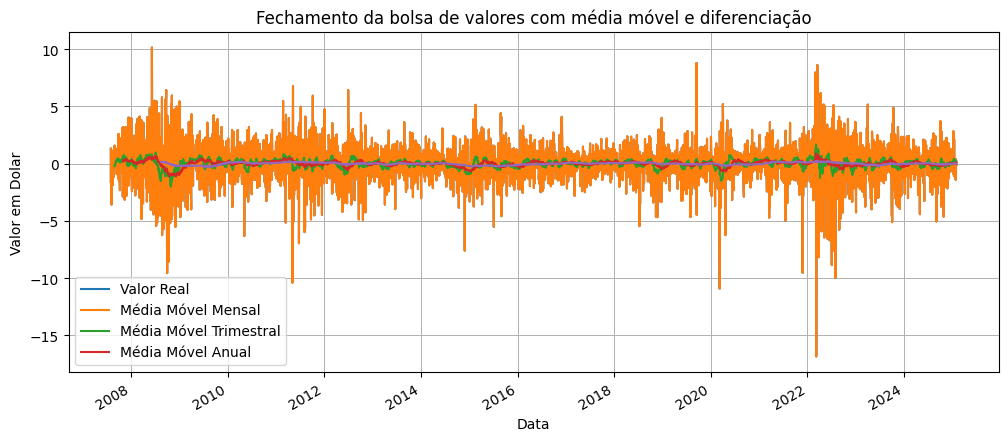

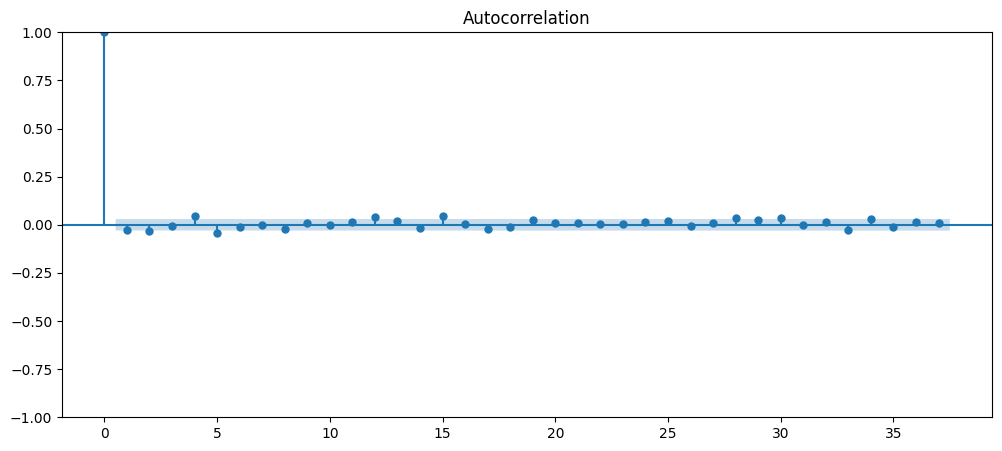

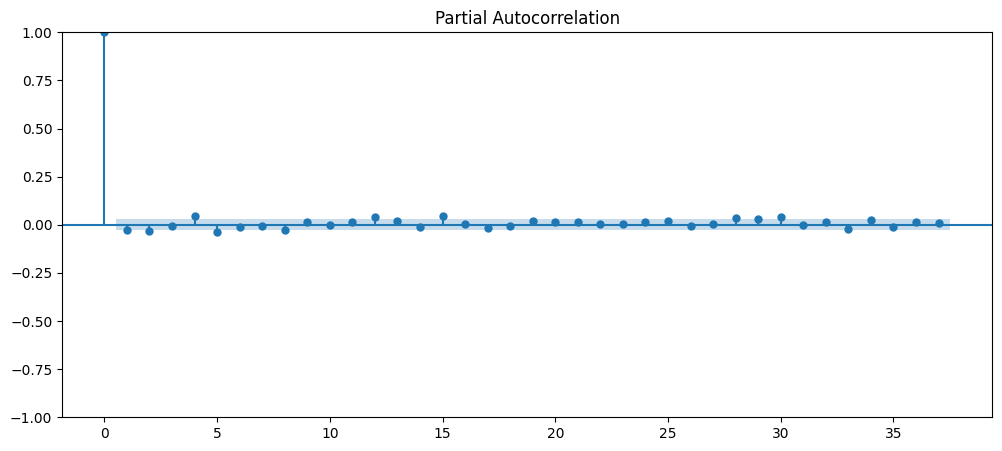

In [290]:
serie = fittado.df['valor_fechamento']


#fittado.plotarSerie(serie)
#plt.show()

#serie.plot()
#fittado.plotar_medias_moveis(serie)

#fittado.avaliacao()
serie_diff = serie.diff().dropna()
serie_diff.plot()

fittado.validacao_kpss(serie_diff)
fittado.validacao_adfuller(serie_diff)

fittado.plotar_medias_moveis(serie_diff, 'Fechamento da bolsa de valores com média móvel e diferenciação')


plot_acf(serie_diff)
plt.show()

plot_pacf(serie_diff)
plt.show()